# **CIS 419/519 Spring 2022 - Homework 5**

**Before starting, you must click on the "Copy To Drive" option in the top bar. Go to File --> Save a Copy to Drive. This is the master notebook so <u>you will not be able to save your changes without copying it </u>! Once you click on that, make sure you are working on that version of the notebook so that your work is saved** 

In [ ]:
# Restart the runtime after running this cell everytime you open the notebook
!pip install pandas==1.1.5

     |████████████████████████████████| 9.5 MB 5.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
np.random.seed(42)  # don't change this line

import dill
import base64

In [ ]:
# For autogreader only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")

[INFO, OK] Google Colab.


# **PennGrader Setup**

First, you'll need to set up the PennGrader, an autograder we are going to use throughout the semester. The PennGrader will automatically grade your answer and provide you with an instant feedback. Unless otherwise stated, you can resubmit up to a reasonable number of attempts (e.g. 100 attemptes per day). **We will only record your latest score in our backend database**. 

After finishing each homework assignment, you must submit your iPython notebook to gradescope before the homework deadline. Gradescope will then retrive and display your scores from our backend database. 

In [ ]:
%%capture
!pip3 install penngrader --upgrade

In [ ]:
from penngrader.grader import *

In [ ]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 19167508          # YOUR PENN-ID GOES HERE AS AN INTEGER#

Run the following cell to initialize the autograder. This autograder will let you submit your code directly from this notebook and immidiately get a score.

**NOTE:** Remember we store your submissions and check against other student's submissions... so, not that you would, but no cheating.

In [ ]:
grader = PennGrader(homework_id = 'CIS_519_Spring22_HW5', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 19167508

Make sure this correct or we will not be able to store your grade


In [ ]:
# A helper function for grading utils
def grader_serialize(obj):        # A helper function
    '''Dill serializes Python object into a UTF-8 string'''
    byte_serialized = dill.dumps(obj, recurse = True)
    return base64.b64encode(byte_serialized).decode("utf-8")

#### **NOTE 1. Results of sections marked as "manually graded" should be submitted along with the written homework solutions.**

#### **NOTE 2. If you are running into a `__builtins__' error, it's likely because you're using a function call of the form numpy.ndarray.mean(), like a.mean(). This does not play nice with PennGrader unfortunately. Please use the function call numpy.mean(a) instead.**

#1.NLP Section

#### Stanford Sentiment Treebank(SST)

We'll introduce the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/index.html) (SST) dataset, and use a Naive Bayes model as a simple baseline. The SST was introduced by [(Socher et al. 2013)](http://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf) and it consists of approximately 10,000 sentences from movie reviews. It consists of 11,855 sentences drawn from a corpus of movie reviews (originally from Rotten Tomatoes), each labeled with sentiment on a five-point scale ans is a widely used dataset as a benchmark for text classification.

An example of the five-point scale is:
```
sentence: [A warm , funny , engaging film .]
label:    4 (very positive)
```

**Note:** Unlike most classification datasets, SST is also a _treebank_, which means each sentence is associated with a tree structure that decomposes it into subphrases. So for the example above, we'd also have sentiment labels for `[warm , funny]` and `[engaging film .]` and so on. The tree structure will comes in handy for complex NLP tasks and we will be using it briefly to analyze an example that has negation. The data is distributed as serialized trees in [S-expression](https://en.wikipedia.org/wiki/S-expression) form, like this:
```
(4 (4 (2 A) (4 (3 (3 warm) (2 ,)) (3 funny))) (3 (2 ,) (3 (4 (4 engaging) (2 film)) (2 .))))
```

We've downladed the dataset and parse the S-expressions into a dataframe.



In [ ]:
!pip3 install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=eca9ca03d1aa82f02e77cc4e8181269cfc80b746c79321311bf82a34c0c41438
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
from __future__ import division
import os, sys, re, json, time, datetime, shutil
import itertools, collections
from importlib import reload

# NLTK, NumPy, and Pandas.
import nltk
from nltk.tree import Tree
import numpy as np
from numpy import random as rd
import random
import pandas as pd

In [ ]:
import os
import collections
import re
import time
import itertools
from collections import defaultdict, Counter

In [ ]:
# Constants for use by other modules.
START_TOKEN = u"<s>"
END_TOKEN   = u"</s>"
UNK_TOKEN   = u"<unk>"

#### Required files
[train parquet file](https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/train.parquet)

[dev parquet file](https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/dev.parquet)

[test parquet file](https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/test.parquet)

[tokens in training data](https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/train_tokens.txt)

In [ ]:
!wget  -c  https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/train_tokens.txt
!wget  -c  https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/train.parquet
!wget  -c  https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/dev.parquet
!wget  -c  https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/test.parquet

--2022-04-14 03:34:08--  https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/train_tokens.txt
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 886453 (866K) [text/plain]
Saving to: ‘train_tokens.txt’

train_tokens.txt    100%[===================>] 865.68K  --.-KB/s    in 0.09s   

2022-04-14 03:34:09 (9.13 MB/s) - ‘train_tokens.txt’ saved [886453/886453]

--2022-04-14 03:34:09--  https://www.cis.upenn.edu/~myatskar/teaching/cis519/a5/train.parquet
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2893816 (2.8M)
Saving to: ‘train.parquet’

train.parquet       100%[===================>]   2.76M  --.-KB/s    in 0.1s    

2022-04-

If the cells above fails to download all the files, rerun a couple of times or download them and add them manually.

In [ ]:
train_file = "train.parquet" 
dev_file = "dev.parquet" 
test_file = "test.parquet" 
vocab_file = "train_tokens.txt" 

Some helper code to download and process data

In [ ]:
#@title
class SSTDataset(object):

    Example_fields = ["tokens", "ids", "label", "is_root", "root_id"]
    Example = collections.namedtuple("Example", Example_fields)


    def canonicalize(self, raw_tokens):
        wordset=(self.vocab.wordset if self.vocab else None)
        return canonicalize_words(raw_tokens, wordset=wordset)

    def __init__(self,train_file,dev_file,test_file,vocab_file,V=20000):
        self.vocab = None
        self.train = pd.read_parquet(train_file)
        self.dev = pd.read_parquet(dev_file)
        self.test = pd.read_parquet(test_file)
        train_words =[]
        with open(vocab_file) as f:
            train_words = f.readlines()
        train_words = [w.strip() for w in train_words]
        # # Build vocabulary over training set
        self.vocab = Vocabulary(train_words, size=V)
        print("Train set has {:,} words".format(self.vocab.size))
        self.target_names = [0,1]

    def get_filtered_split(self, split='train',is_root = True):
        df = getattr(self, split)
        if is_root:
            df = df[df.is_root]
        return df

    def as_padded_array(self, split='train', max_len=40, pad_id=0,is_root = True):
        df = self.get_filtered_split(split,is_root)
        x, ns = pad_np_array(df.ids, max_len=max_len, pad_id=pad_id)
        y = np.empty((1,1))
        if split != 'test':
            y  = np.array(df.label, dtype=np.int32)
        return x, ns, y

    def as_sparse_bow(self, split='train',is_root = True):
        from scipy import sparse
        df = self.get_filtered_split(split,is_root)
        x = id_lists_to_sparse_bow(df['ids'], self.vocab.size)
        if split != 'test':
            return x, np.array(df.label, dtype=np.int32)
        return x

def require_package(package_name):
    import pkgutil
    import subprocess
    import sys
    if not pkgutil.find_loader(package_name):
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package_name])

def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset):
        return word
    else:
        return UNK_TOKEN

def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]


def pad_np_array(example_ids, max_len=250, pad_id=0):
    arr = np.full([len(example_ids), max_len], pad_id, dtype=np.int32)
    ns = np.zeros([len(example_ids)], dtype=np.int32)
    for i, ids in enumerate(example_ids):
        cpy_len = min(len(ids), max_len)
        arr[i,:cpy_len] = ids[:cpy_len]
        ns[i] = cpy_len
    return arr, ns

def id_lists_to_sparse_bow(id_lists, vocab_size):
    from scipy import sparse
    ii = []  # row indices (example ids)
    jj = []  # column indices (token ids)
    for row_id, ids in enumerate(id_lists):
        ii.extend([row_id]*len(ids))
        jj.extend(ids)
    x = sparse.csr_matrix((np.ones_like(ii), (ii, jj)),
                          shape=[len(id_lists), vocab_size])
    return x

class Vocabulary(object):

    START_TOKEN = START_TOKEN
    END_TOKEN   = END_TOKEN
    UNK_TOKEN   = UNK_TOKEN

    def __init__(self, tokens, size=None,
                 progressbar=lambda l:l):
        self.unigram_counts = Counter()
        self.bigram_counts = defaultdict(lambda: Counter())
        prev_word = None
        for word in progressbar(tokens):  # Make a single pass through tokens
            self.unigram_counts[word] += 1
            self.bigram_counts[prev_word][word] += 1
            prev_word = word
        self.bigram_counts.default_factory = None  # make into a normal dict

        # Leave space for "<s>", "</s>", and "<unk>"
        top_counts = self.unigram_counts.most_common(None if size is None else (size - 3))
        vocab = ([self.START_TOKEN, self.END_TOKEN, self.UNK_TOKEN] +
                 [w for w,c in top_counts])

        # Assign an id to each word, by frequency
        self.id_to_word = dict(enumerate(vocab))
        self.word_to_id = {v:k for k,v in self.id_to_word.items()}
        self.size = len(self.id_to_word)
        if size is not None:
            assert(self.size <= size)

        # For convenience
        self.wordset = set(self.word_to_id.keys())

        # Store special IDs
        self.START_ID = self.word_to_id[self.START_TOKEN]
        self.END_ID = self.word_to_id[self.END_TOKEN]
        self.UNK_ID = self.word_to_id[self.UNK_TOKEN]

    def words_to_ids(self, words):
        return [self.word_to_id.get(w, self.UNK_ID) for w in words]

    def ids_to_words(self, ids):
        return [self.id_to_word[i] for i in ids]

    def ordered_words(self):
        """Return a list of words, ordered by id."""
        return self.ids_to_words(range(self.size))


In [ ]:
ds = SSTDataset(train_file,dev_file, test_file,vocab_file,V=20000)

Train set has 16,474 words


A few members of the `SSTDataset()` class that we will be using are:
- **`ds.vocab`**: a `vocabulary.Vocabulary` object managing the model vocabulary.
- **`ds.{train,dev,test}`**: a Pandas DataFrame containing the _processed_ examples, including all subphrases. `label` is the target label, `is_root` denotes whether this example is a root node (full sentence), and `tokens` are the tokenized words from the original sentence.

##  1.1 Naive Bayes Classifier [TODO: 10 pts]

We're now going to build a Naive Bayes Classifer.

Naive Bayes is perhaps the simplest possible classification algorithm, but it's one that still surprisingly effective for many text classification problems. Recall the following formulae:

$$
 P(y = k) = \hat{\theta}_k = \frac{1}{N}\sum_{i = 1}^N \mathbf{1}[y_i = k] $$

$$ P(x_j | y = 1) = \hat{\theta}_{k,j} = 
\frac{ 
\sum_{i = 1}^N  \sum_{j' = 1}^{n_i} \mathbf{1}[y_i = 1 \wedge x_{j'} = j]
}{
\sum_{i = 1}^N  \mathbf{1}[y_i = 1] \cdot n_i
}
$$

where $N$ is the size of the dataset, and $n_i$ is the length (number of tokens of the $i^{th}$ example. Prediction is done by computing the score:

$$ \mathrm{score}(x) = \log \left(\frac{P(y = 1) \prod_{j=1}^n P(x_j | y = 1)}{P(y = 0) \prod_{j=1}^n P(x_j | y = 0)}\right) $$

We'll just use the [implementation from scikit-learn](http://scikit-learn.org/stable/modules/naive_bayes.html). We will be using the `scipy.sparse` matrix representation.

Note if you set `root_only=True` the dataframe will return only examples corresponding to whole sentences. If you set `root_only=False` the dataframe will return examples for all phrases.

In [ ]:
is_root = False

We will get the input for Naive Bayes as a "Compressed Sparse Row", which is one format for representing sparse matricies.

In [ ]:
train_x_csr, train_y = ds.as_sparse_bow("train",is_root= is_root)
dev_x_csr, dev_y = ds.as_sparse_bow("dev",is_root= is_root)
test_x_csr = ds.as_sparse_bow("test",is_root= is_root)

print("Training set: x = {:s} sparse, y = {:s}".format(str(train_x_csr.shape), 
                                                str(train_y.shape)))
print("Validation set: x = {:s} sparse, y = {:s}".format(str(dev_x_csr.shape), 
                                                str(dev_y.shape)))
print("Test set: x = {:s} sparse".format(str(test_x_csr.shape)))

Training set: x = (98794, 16474) sparse, y = (98794,)
Validation set: x = (13142, 16474) sparse, y = (13142,)
Test set: x = (26052, 16474) sparse


Implement Naive Bayes using `sklearn.naive_bayes.MultinomialNB`. 

For this part of the exercise, do the following:
 and evaluate accuracy on the dev set using `.predict

1.   Train on the training set.
2.   Validate the accuracy on the dev set. 
3.   Return the predictions for the test set.


Your model should train almost instantly. On SST, Naive Bayes is actually a very strong baseline.



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
#Return acc and y_pred_test where acc is the accuracy for the dev set and y_pred_test is the list of predictions for the test set

def Naive_Bayes(train_x_csr, train_y, dev_x_csr, dev_y, test_x_csr):
    """
    Trains the Multinomial Naive Bayes Classifier
    
    INPUT:
    train_x_csr - sparse matrix representation for train dataset
    train_y     - train data labels
    dev_x_csr   - sparse matrix representation for dev dataset
    dev_y       - train data labels
    test_x_csr  - sparse matrix representation for test dataset
    
    OUTPUT:
    nb          - the Multinomial Naive Bayes Classifier
    test_y_pred - the predictions for the test set
    
    """
    #### STUDENT CODE HERE ####
    #TODO use multinomial naive bayes to train 
    nb = MultinomialNB()
    nb.fit(train_x_csr, train_y)
    test_y_pred = nb.predict(test_x_csr)
    #### END ####
    return nb, test_y_pred

In [ ]:
nb, test_y_pred = Naive_Bayes(train_x_csr, train_y, dev_x_csr, dev_y, test_x_csr)

In [ ]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_nb_predictions', answer = test_y_pred)

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### Examining featues
Let us look at the most positive and negative features in the training set

In [ ]:
w = nb.feature_log_prob_[1, :] - nb.feature_log_prob_[0, :]
linear_weights = nb.feature_log_prob_[1, :] - nb.feature_log_prob_[0, :] 
idx_sorted = np.argsort(w)
top_negative_features = idx_sorted[:10]
top_positive_features = idx_sorted[-10:][::-1]


print("Most negative features:")
for idx in top_negative_features:
    print("  {:s} ({:.02f})".format(ds.vocab.id_to_word[idx], 
                                    linear_weights[idx]))
print("")
print("Most positive features:")
for idx in top_positive_features:
    print("  {:s} ({:.02f})".format(ds.vocab.id_to_word[idx], 
                                    linear_weights[idx]))

Most negative features:
  unfunny (-5.05)
  poorly (-4.93)
  pointless (-4.84)
  tiresome (-4.62)
  inept (-4.45)
  unnecessary (-4.41)
  lousy (-4.38)
  listless (-4.38)
  crap (-4.33)
  unimaginative (-4.28)

Most positive features:
  stunning (4.42)
  wonderfully (4.32)
  detailed (4.26)
  heartwarming (4.25)
  thought-provoking (4.23)
  refreshingly (4.22)
  elegant (4.21)
  evocative (4.18)
  vibrant (4.05)
  masterful (4.04)


## 1.2 [Deep Averaging Networks](https://people.cs.umass.edu/~miyyer/pubs/2015_acl_dan.pdf)

We are going to implement the deep averaging networks

![dan](https://miro.medium.com/max/904/1*0LezMYWUk3pXptoMdO5M_Q.png)


Vector space models for natural language processing (NLP) represent words using low dimensional vectors called embeddings. To apply vector space
models to sentences or documents, one must first select an appropriate composition function, which combines multiple words into a single vector.

Composition functions fall into two classes: unordered and syntactic. Unordered functions treat input texts as bags of word embeddings, while syntactic functions take word order and sentence structure
into account. Syntactic functions outperform unordered functions on many tasks. However, there is a tradeoff: syntactic functions require more training time and computing resources. 

The deep averaging network (DAN) is a deep unordered model which that obtains near state-of-the-art accuracies on a variety of sentence and document-level tasks with just minutes of training time on an average laptop computer. It
works in three simple steps:
1. Take the vector average of the embeddings
associated with an input sequence of tokens
2. Pass that average through one or more feedforward layers
3. Perform (linear) classification on the final
layer’s representation

Furthermore, DANs, can be effectively trained on data that have high syntactic variance. The model works by magnifying tiny but meaningful differences in the vector average.

We are going to use DANs for the same classification problem.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [ ]:
import os
import time
import glob
import numpy as np

import sys
from argparse import ArgumentParser

### 1.2.1 [Glove Embeddings](https://nlp.stanford.edu/projects/glove/) [TODO: 5pts]
We are downloading pretrained glove word vectors that has been trained on Common Crawl data, a snapshot of the whole web.
These embeddings serve as excelent initilizations for embeddings our model needs.
Downloading glove embeddings (This will take around 10 minutes) 

In [ ]:
#this takes about 10 minutes to run
!wget -nc https://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip
!ls -lat

--2022-04-14 03:34:18--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2022-04-14 03:34:18--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘glove.840B.300d.zip’

glove.840B.300d.zip 100%[===================>]   2.03G  5.19MB/s    in 6m 51s  

2022-04-14 03:41:09 (5.05 MB/s) - ‘glove.840B.300d.zip’ saved [2176768927/2176768927]

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     

total

In [ ]:
glove_file = "glove.840B.300d.txt"

In [ ]:
train_x, train_ns, train_y = ds.as_padded_array("train",is_root = is_root)
dev_x, dev_ns, dev_y = ds.as_padded_array("dev",is_root = is_root)
test_x, test_ns,_  = ds.as_padded_array("test",is_root = is_root)

print("Training set: x = {:s} sparse, ns={:s}, y = {:s}".format(str(train_x.shape), str(train_ns.shape),
                                                str(train_y.shape)))
print("Validation set: x = {:s} sparse,ns={:s}, y = {:s}".format(str(dev_x.shape), str(dev_ns.shape),
                                                str(dev_y.shape)))
print("Test set:     x = {:s} sparse,ns={:s}".format(str(test_x.shape), str(test_ns.shape)))

Training set: x = (98794, 40) sparse, ns=(98794,), y = (98794,)
Validation set: x = (13142, 40) sparse,ns=(13142,), y = (13142,)
Test set:     x = (26052, 40) sparse,ns=(26052,)


In [ ]:
#look at the format of the file
!head glove.840B.300d.txt

, -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -0.47215 -0.18366 -0.3

#### Get Glove embeddings
In this section we want to populate the `glove` dictionary with a mapping of word to the embedding. Remember: the embedding should be an `np.array` of type `np.float` The glove dictionary should only have words that are present in the train vocabulary. 


Hint: 
 

For getting the word and corresponding embedding from the glove file, remember refer to the above structure of the word to embedding mapping.

In [ ]:
#takes about 1 minute to read through the whole file and find the words we need. 
def get_glove_mapping(vocab, file):
    """
    Gets the mapping of words from the vocabulary to pretrained embeddings
    
    INPUT:
    vocab       - set of vocabulary words
    file        - file with pretrained embeddings

    OUTPUT:
    glove_map   - mapping of words in the vocabulary to the pretrained embedding
    
    """
    
    glove_map = {}
    with open(file,'rb') as fi:
        for l in fi:
            try:
              #### STUDENT CODE HERE ####
              l = l.decode('utf-8')
              values = l.split()
              w = values[0]
              if w in vocab:
                c = np.array(values[1:], dtype = np.float32)
                glove_map[w] = c
  
                #### STUDENT CODE ENDS HERE ####
            except:
                #some lines have urls, we don't need them.
                pass
    return glove_map

In [ ]:
vocab_set = set(ds.vocab.ordered_words())
glove_map = get_glove_mapping(vocab_set,glove_file)

In [ ]:
def test_glove_embedding(glove_map):
    assert(len(glove_map.keys()) == 15505)
    assert("November" not in glove_map.keys())

if NOTEBOOK:
    test_glove_embedding(glove_map)

In [ ]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_glove_embedding', answer = list(glove_map.keys()))

#### Dimensions required for the weight matrix

Fill in the dimensions required for weight matrix

In [ ]:
d_out = len(ds.target_names)  #number of outputs
n_embed = ds.vocab.size #size of the dictionary of embeddings
d_embed = 300 # the size of each embedding vector
dims =(d_out,n_embed,d_embed)

In [ ]:
def test_dimensions(dims):
    d_out,n_embed,d_embed = dims 
    assert(n_embed == 16474)
    assert(d_out == 2)
    assert(d_embed == 300)
    
if NOTEBOOK:
    test_dimensions(dims)

In [ ]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_dimensions', answer = dims)

#### Initializing the weight matrix

Create a weight_matrix for the parameters to be learnt. Initialize the weight matrix for a particular id with the glove embedding for the same id. If you do not find a particular word, initialize the weight matrix with `np.random.normal`

Hint: `ds.vocab.ordered_words()` can give you the mapping of id to words. `glove` has the embeddings you need.

In [ ]:
def get_weight_matrix(n_embed, d_embed, glove_map):
    """
    Initialize the weight matrix
    
    INPUT:
    n_embed         - size of the dictionary of embeddings
    d_embed         - the size of each embedding vector

    OUTPUT:
    weights_matrix  - matrix of mapping from word id to embedding 
    
    """
    #### STUDENT CODE HERE ####
    weights_matrix = np.random.normal(size=(n_embed,d_embed))
    i = 0 
    for each in ds.vocab.ordered_words():
      if each in glove_map:
        weights_matrix[i] = glove_map.get(each)
      i+=1
    weights_matrix = weights_matrix.astype(np.float16)
    
    #### STUDENT CODE ENDS HERE ####
    return weights_matrix

In [ ]:
weights_matrix = get_weight_matrix(n_embed, d_embed, glove_map)
weight_data = (weights_matrix.shape, weights_matrix[:155])

In [ ]:
def test_weight_matrix(weight_data):
    mat1 = [-0.18994 ,  0.11016 , -0.46874 ,  0.24375 ,  0.18241 ,  0.2649  ,
       -0.025122, -0.58228 , -0.23545 ,  0.20763 ]
    shape = (16474, 300)
    for i in range(0,10):
        if abs(mat1[i] - weight_data[1][150][200+i])>= 0.002:
            assert(mat1[i] != weight_data[1][150][200+i])
        if shape != weight_data[0]:
            assert(shape != weight_data[0])

if NOTEBOOK:
    test_weight_matrix(weight_data)

In [ ]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_weight_matrix', answer = weight_data)

#### Creating Embedding Layer
Use the weight matrix to create the embedding layer by using `nn.Embedding`.

In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False):
    """
    Create the embedding layer
    
    INPUT:
    weights_matrix  - matrix of mapping from word id to embedding
    non_trainable   - Flag for whether the weight matrix should be trained. 
                      If it is set to True, don't update the gradients

    OUTPUT:
    emb_layer       - embedding layer 
    
    """
    #### STUDENT CODE HERE ####
    d = weights_matrix.shape[1]
    n = weights_matrix.shape[0]
    emb_layer = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix.astype(np.float32)),freeze = non_trainable)
    #### STUDENT CODE ENDS HERE ####

    return emb_layer

#### Defining the Dataloader 

For the ease of batch processing, we are defining the following to use the functionality of the Dataloader in Pytorch. 

Note: The process of creating a mask for the word dropout.

In [ ]:
class SSTpytorchDataset(Dataset):
    def __init__(self, sst_ds, word_dropout = 0.3, split='train'):
        super(SSTpytorchDataset, self).__init__()
        assert split in ['train', 'test', 'dev'], "Error!"
        self.ds = sst_ds
        self.split = split
        self.word_dropout = word_dropout
        self.data_x, self.data_ns, self.data_y = self.ds.as_padded_array(split,is_root =is_root)
        self.mask = np.zeros_like(self.data_x)

    def __len__(self):
        return self.data_x.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        y = 2
        if self.split != 'test':
            y = self.data_y[idx]

        #Returning the mask for the dataloader

        mask = np.zeros(len(self.data_x[idx]))
        sentl = self.data_ns[idx]
        total_dropped = 0
        for j in range(0,sentl):
            mask[j] = 1
            if self.split == 'train': 
                rv = random.random()
                if rv  < self.word_dropout: 
                    mask[j] = 0 
                    total_dropped+=1
        if total_dropped >= sentl: 
            mask[0] = 1
        for i in range(sentl,len(self.data_x[idx])):
            mask[i] = 0
        self.mask[idx] = mask        
        return self.data_x[idx], self.data_ns[idx], self.mask[idx], y
        

### 1.2.2 Training [TODO: 20 pts]

####  Masked Averaging

In this section, you will need to compute the average word embedding of tokens in the input. One complication is that sentences come in different lengths, and we will need to keep track of this to correctly average. 

When a sentence is input into our network, it is mapped to list of token ids, up to some maximum length. We construct a matrix, M, where each row corresponds to a sentence, and entries correspond to integers representing tokens. Some sentences are, of course, shorter than this maximum length. For these sentences, we fill in the remaining elements of M with a pad index, up to the max length. This is a special pad index indicating we are beyond the end of a sentence. The dataloader takes care of this for you. When averaging, we need to ignore these elements. 

Irrespective of if a token is pad or a real token, the first step is to look up an embedding for the index in our embedding table (the first line of the forward method). At this point we will have retrieved some vectors that correspond to the pad tokens as well. We need to ignore these, and only average vectors that correspond to non-pad symbols. 

To help do so, often NLP applications will introduce a mask as part of the input. The mask is a binary vector for every sentence, where each position encodes whether the token is really from the sentence, or instead should be ignored. The shape of the mask is batch_size by maximum_length. Again, the dataloader has taken care of this for you. Your job will be to use this mask to ignore the embeddings components we don't want to average over.

You have to perform the following steps:

1. Change the view of the mask so it extends to the embeddings size. It started batch_size by maximum_length, but we need it to be batch_size by max_length by embed_dimension. The expand function will help.
2. Pointwise multiply the expanded mask with the embeddings, to eliminate the tokens that aren't in the mask, and sum the rest (this is the `numerator` of our average). Remeber the mask is a binary vector, so the zeros correspond to elements we don't want in our average. The output of this sum should be batch_size by embed_dimension.
4. Calculate the number of words in each sentence (this is the `denominator` of our average)
3. return `x = numerator/denoninator` , the average

Note: You can look at [expand](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) in pytorch. 

#### Defining the architecture for Deep Averaging Networks

In [ ]:
import random as random

class DAN(nn.Module):

    def __init__(self,
                 n_embed=20000,
                 d_embed=300,
                 d_hidden=100,
                 d_out=2,
                 layer_dropout = 0.2,
                 word_dropout = 0.3,
                 embeddings=None,
                 depth = 0):
        super(DAN, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.embed = create_emb_layer(weights_matrix,False)

        self.fc_out = nn.Linear(d_hidden, d_out)
        self.word_dropout = word_dropout

    def masked_mean(self,v, mask):
        """
        Create the masked mean
        
        INPUT:
        v       - input
        mask    - mask that has 0 and 1 for all the tokens in the input
                  0 corresponds to a token we should not include in the average and 1 otherwise

        OUTPUT:
        x       - average  
        
        """
        (batch, max_sent, d_embed ) = v.size() #these values we will be useful for expanding the mask      
        #### STUDENT CODE HERE ####
        mask_new = mask.unsqueeze(-1)
        mask_new = mask_new.expand(v.size())
        m = mask_new * v 
        c = torch.sum(mask,dim =1)
        n = torch.sum(m,dim=1)
        x = torch.div(n,c[:,None])

        #### STUDENT CODE ENDS HERE ####
        return x

    def forward(self, text_ids, mask):
        embeddings = self.embed(text_ids) #this is a matrix of embeddings, one for each id, of size batch_size X max_sent_size X embedding dimension
        avg = self.masked_mean(embeddings,mask) #should return the average of the embeddings, ignoring the embeddings corresponding to the pad token
        output = self.fc_out(avg) #final classification layer
        return output

#### Training Loop

In [ ]:
criterion = nn.CrossEntropyLoss()

batch_size = 64
epochs = 3
dev_every = 100
lr = 0.001
save_path = "best_model"
drop_out = 0
word_dropout = 0.01
weight_decay = 1e-5

In [ ]:

def train(lr = .005, drop_out = 0, word_dropout = .3, batch_size = 16, weight_decay = 1e-5,args = None):
    if args is not None:
      drop_out = args["drop_out"]
      drop_out = args["drop_out"]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trainset = SSTpytorchDataset(ds, word_dropout, 'train')
    testset = SSTpytorchDataset(ds, word_dropout, 'test')
    devset = SSTpytorchDataset(ds, word_dropout, 'dev')

    train_iter = DataLoader(trainset, batch_size, shuffle=True, num_workers=0)
    test_iter = DataLoader(testset, batch_size, shuffle=False, num_workers=0)
    dev_iter = DataLoader(devset, batch_size, shuffle=False, num_workers=0)
    
    model = DAN(n_embed=n_embed, d_embed=d_embed, d_hidden=300, d_out=d_out, layer_dropout=drop_out, word_dropout = word_dropout )
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay = weight_decay)


    acc, val_loss = evaluate(dev_iter, model, device)
    best_acc = acc

    print(
        'epoch |   %        |  loss  |  avg   |val loss|   acc   |  best  | time | save |')
    print(
        'val   |            |        |        | {:.4f} | {:.4f} | {:.4f} |      |      |'.format(
            val_loss, acc, best_acc))

    iterations = 0
    last_val_iter = 0
    train_loss = 0
    start = time.time()
    _save_ckp = ''
    for epoch in range(epochs):
        # train_iter.init_epoch()
        n_correct, n_total, train_loss = 0, 0, 0
        last_val_iter = 0
        for batch_idx, batch in enumerate(train_iter):
            # switch model to training mode, clear gradient accumulators
            model.train();
            optimizer.zero_grad()

            iterations += 1

            data, ns, mask, label = batch
            
            data = data.to(device)
            label = label.to(device).long()
            mask = mask.to(device).long()
            mask.requires_grad = False

            answer = model(data,mask)
            loss = criterion(answer, label)

            loss.backward();
            optimizer.step()

            train_loss += loss.item()
            print('\r {:4d} | {:4d}/{} | {:.4f} | {:.4f} |'.format(
                epoch, batch_size * (batch_idx + 1), len(trainset), loss.item(),
                       train_loss / (iterations - last_val_iter)), end='')

            if iterations > 0 and iterations % dev_every == 0:
                acc, val_loss= evaluate(dev_iter, model, device)

                if acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), save_path)
                    _save_ckp = '*'

                print(
                    ' {:.4f} | {:.4f} | {:.4f} | {:.2f} | {:4s} |'.format(
                        val_loss, acc, best_acc, (time.time() - start) / 60,
                        _save_ckp))

                train_loss = 0
                last_val_iter = iterations
    model.load_state_dict(torch.load(save_path)) #this will be the best model
    test_y_pred = evaluate(test_iter,model, device,"test")
    print("\nValidation Accuracy : ", evaluate(dev_iter,model, device))
    return best_acc, test_y_pred


In [ ]:

def evaluate(loader, model, device, split = "dev"):
    model.eval()
    n_correct, n = 0, 0
    losses = []
    y_pred = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            data, ns, mask, label = batch
            data = data.to(device)
            label = label.to(device).long()
            mask = mask.to(device).long()
            answer = model(data,mask)
            if split != "test":
                n_correct += (torch.max(answer, 1)[1].view(label.size()) == label).sum().item()
                n += answer.shape[0]
                loss = criterion(answer, label)
                losses.append(loss.data.cpu().numpy())
            else:
                y_pred.extend(torch.max(answer, 1)[1].view(label.size()).tolist())
    if split != "test":
        acc = 100. * n_correct / n
        loss = np.mean(losses)
        return acc, loss
    else:
        return y_pred


Run this to get the validation accuracy on the dev dataset and the predictions of the test dataset.

In [ ]:
torch.manual_seed(1234)

epochs = 3 
dev_value, test_y_pred = train(lr, batch_size, word_dropout, batch_size, weight_decay) 

In [ ]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_dan_predictions', answer = test_y_pred)

#2.Reinforcement Learning Section

In [ ]:
if NOTEBOOK:
  """
  installing dependencies
  """
  !apt-get update
  !apt-get -qq -y install libnvtoolsext1 > /dev/null
  !ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
  !apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
  !pip -q install gym
  !pip -q install pyglet
  !pip -q install pyopengl
  !pip -q install pyvirtualdisplay
  !apt-get install xvfb

In [ ]:
"""
Imports
"""

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
import random
from gym import wrappers
import torch
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os

import matplotlib.animation
import numpy as np
from IPython.display import HTML

In [ ]:
## Wrapper for Rendering the Environment

class ResizeObservation(gym.Wrapper):
    def __init__(self, env, shape):
        super(ResizeObservation, self).__init__(env)
        if isinstance(shape, int):
            shape = (shape, shape)
        assert all(x > 0 for x in shape), shape
        self.env = env
        self.shape = tuple(shape)

    def render(self):

        from PIL import Image
        obs = self.env.render(mode = 'rgb_array')
        im = Image.fromarray(np.uint8(obs))
        im = im.resize(self.shape)
        return np.asarray(im)

resize_observation_shape = 100


### 4.1 Discretize the state [TODO: 3pts]

The state of Mountain Car is represented by a vector of 2 (float) values. The first element of the state vector represents the cart’s position, and the second element represents the cart’s velocity. You can use `env.observation_space.low` and `env.observation_space.high` to find out its upper and lower bound. 


As you can see the state space of the Mountain Car is continuous, which means that there are infinitely many state-action pairs , making basic Q-learning impossible to satisfy this condition. Instead, for a simple environment like Mountain Car, we can discretize the continuous state space and round the state to nearest discretization state. Then use the discretization state as the index of Q value matrix.

For example, let us say you have a continuous state with range of [0.5, 1], and you want to discretize it in the range [1, 100] (only integers). You have to linearly map the continuous interval [0.5, 1] to the discrete interval [1, 100], therefore a number like .75 would go to 25. 

The linear mapping from a continuous value $c$ to its equivalent discrete value $d$ would be expressed as:

$$d = \text{round}\left((c - state.minimum) * discretization scale \right)$$

In [ ]:
def discretize(state, discretization, env):
    """    
    Discretize the continuous state to a given discretization range.
    Args:
        state (np.array, shape=(2,)): the observation state, here it is [position, velocity]
        discretization(np.array, shape=(2,)): the discretization ,by default, it is np.array([100,10])
        env: the RL environment 
        
    Returns:
        discretized_state (np.array, shape=(2,), dtype=int): the discretized state
    """

    ### STUDENT's TODO ###
    a = round((state[0]-env.observation_space.low[0])*discretization[0])
    b = round((state[1]-env.observation_space.low[1])*discretization[1])
    discretized_state = np.array([a,b])   
    return discretized_state

In [ ]:
def test_discretization():
    test_state = np.array([0.556, 0.6])
    discretization = np.array([100, 10])
    env = gym.make('MountainCar-v0')
    env = ResizeObservation(env, resize_observation_shape)
    d = discretize(test_state, discretization, env)
    print(d)
    if d.shape != tuple([2]) or d[0] != 176 or d[1] != 7:
        print("Incorrect discretization")
    else:
        print("Well done")

if NOTEBOOK == 1:
    test_discretization()
    

In [ ]:
# PennGrader Grading Cell
if NOTEBOOK:
    test = np.array([.12,.56])
    space = np.array([6,20])
    env = gym.make('MountainCar-v0')
    d = discretize(test, space, env)
    grader.grade(test_case_id = 'test_discretize', answer = d)

### 4.2 Choose action for a certain state [TODO: 2pts]

Suppose now you are already given a state and a certain Q value matrix, the naive way is just choosing the action with highest Q value. However, in the real world it's better to consider the randomness of the action while learning, it could lead to a more robust controller and also let agent explore the environment.

In this part, you need to implement an **epsilon greedy strategy** to choose action for a certain state.  **Epsilon greedy strategy** means that, given a threshold epsilon (between 0 and 1), your controller would have the probability of epsilon of just outputing a random action. For the rest of the time, it chooses the action with highest Q value. 

Implement this strategy in the `choose_action` function.

In [ ]:
def choose_action(epsilon, Q, state, env):
    """    
    Choose an action according to an epsilon greedy strategy.
    Args:
        epsilon (float): the probability of choosing a random action
        Q (np.array): The Q value matrix, here it is 3D for the two observation states and action states
        state (np.array): the observation state, here it is [position, velocity]
        env: the RL environment 
        
    Returns:
        action (int): the chosen action
    """
    action = 0
    random.seed(42)
    if random.random()<= epsilon:
      action = np.random.randint(0,3)
    else:
      temp = Q[state[0], state[1], :]
      action = np.argmax(temp)
    ### STUDENT's TODO ###


    return action


In [ ]:

def test_choose_action_shape():
    Q = np.random.uniform(low = -1, 
                        high = 1, 
                        size = (100, 10, env.action_space.n))
    a = [choose_action(0.7, Q, (5, 3), env) for i in range(1000)]
    if type(a[0]) == int and a[0] < env.action_space.n:
        print("Looks like the right shape")
    else:
        print("Incorrect return value (wrong type or higher than the number of action types)")

def test_choose_action_nondeterminacy():
    Q = np.random.uniform(low = -1, high = 1, size = (100, 10, env.action_space.n)) #added this in myself since Q was never defined before (I think a bug?)
    a = [choose_action(0.7, Q, (5, 3), env) for i in range(1000)]
    if len(set(a)) > 1:
        print("Looks nondeterministic")
    else:
        print("Probably too deterministic")
if NOTEBOOK == 1:
    test_choose_action_nondeterminacy()
    test_choose_action_shape()


In [ ]:
from numpy.random.mtrand import seed
# PennGrader Grading Cell
if NOTEBOOK:
    np.random.seed(42)
    Q = np.random.uniform(low = -1, 
                        high = 1, 
                        size = (100, 10, env.action_space.n))
    a = [choose_action(0.7, Q, (5, 3), env) for i in range(10)]
    grader.grade(test_case_id = 'test_choose_action', answer = a)

### 4.3 Decay epsilon [TODO: 1pts]

In the Q-learning, we want the agent to explore the environment while efficiently reach the goal. 

Therefore, we usually set a high epsilon at the beginning of each trajectory, and decay the epsilon in the following steps. 

Implement the decay epsilon function for a certain step in the `update_epsilon` function.

In [ ]:
def update_epsilon(epsilon, decay_rate):
    """
    Decay epsilon by the specified rate. Note: it should be just one line of code.
    
    Args:
        epsilon (float): the probability of choosing a random action
        decay_rate (float): the decay rate (between 0 and 1) to scale epsilon by
        
    Returns:
        updated epsilon
    """
  
    ### STUDENT's TODO ###
    epsilon = epsilon*decay_rate

    return epsilon


In [ ]:
def testUpdateEpsilon():
    orig_ep = 0.51
    decay = 0.97
    new_ep = update_epsilon(orig_ep, decay)
    if not type(new_ep) == float:
        print("Wrong type returned")
    elif new_ep != 0.4947:
        print("Incorrect implementation")
    else:
        print("Implementation of update_epsilon correct")

if NOTEBOOK == 1:
    (testUpdateEpsilon())

In [ ]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_update_epsilon', answer = update_epsilon)

### 2.4 Update Q Value [5 pts]


Recall the incremental Q Value update function is:

$$Q(s,a) = Q(s,a)+ \alpha(R(s,a,s')+\gamma\max_{a'}Q(s',a')-Q(s,a) )$$

Where $s$ is current state, $s'$ is next state, $a$ is current action, $a'$ is next possible action, $\alpha$ is learning rate, $\gamma$ is discount rate, $s'$ is next state. $Q(s,a)$ is Q value for a certain state and action pair, $R(s,a,s')$ is the reward of applying the state and action pair that arrive at $s'$. $Q(s',a')$ is the Q value of state action pair $(s',a')$. Implement the `update_Q` function.

In [ ]:
from gym.core import RewardWrapper
def update_Q(Q, state_disc, next_state_disc, action, discount, learning_rate, reward, terminal):
    """
    
    Update Q values following the Q-learning update rule. 
    
    Be sure to handle the terminal state case.
    
    Args:
        Q (np.array): The Q value matrix, here it is 3D for the two observation states and action states
        state_disc (np.array): the discretized version of the current observation state [position, velocity]
        next_state_disc (np.array): the discretized version of the next observation state [position, velocity]
        action (int): the chosen action
        discount (float): the discount factor, may be referred to as gamma
        learning_rate (float): the learning rate, may be referred to as alpha
        reward (float): the current (immediate) reward
        terminal (bool): flag for whether the state is terminal
        
    Returns:
        Q, with the [state_disc[0], state_disc[1], action] entry updated.
    """    
    ### STUDENT's TODO ###
    q = Q[state_disc[0], state_disc[1], action]
    a_new = np.argmax(Q[next_state_disc[0],next_state_disc[1],:])
    q_new = Q[next_state_disc[0],next_state_disc[1],a_new]
    Q[state_disc[0], state_disc[1], action]=q + learning_rate*(reward+discount*q_new-q)
    return Q
    
def test_update_Q():
    Q = np.ones((3, 3, env.action_space.n))
    state_disc = (2, 2)
    next_state_disc = (2,1)
    action = 1
    discount = 0.9
    learning_rate = 0.01
    reward = 10
    terminal = False
    Q = update_Q(Q,state_disc,next_state_disc,action,discount,learning_rate, reward, terminal) 
    if Q.tolist() != [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]], [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]], [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.099, 1.0]]]:
        print("Incorrect Q update")
    else:
        print("Q update looks correct!")

if NOTEBOOK == 1:    
    test_update_Q()

In [ ]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_update_Q_backend', answer = (update_Q, env.action_space.n))

###2.5 Main Q-learning Loop

In [ ]:
class ResizeObservation(gym.Wrapper):
    def __init__(self, env, shape):
        super(ResizeObservation, self).__init__(env)
        if isinstance(shape, int):
            shape = (shape, shape)
        assert all(x > 0 for x in shape), shape
        self.env = env
        self.shape = tuple(shape)

    def render(self):

        from PIL import Image
        obs = self.env.render(mode = 'rgb_array')
        im = Image.fromarray(np.uint8(obs))
        im = im.resize(self.shape)
        return np.asarray(im)

You have implemented all the untility functions for Q-learning. We've provided you the code for the main Q-learning loop, please carefully go through the next cell.

In [ ]:
def Qlearning(Q, discretization, env, learning_rate, discount, epsilon, decay_rate, max_episodes=5000):
    """
    
    The main Q-learning function, utilizing the functions implemented above.
          
    """
    reward_list = []
    position_list = []
    success_list = []
    success = 0 # count of number of successes reached 
    frames = []
  
    for i in range(max_episodes):
        # Initialize parameters
        done = False # indicates whether the episode is done
        terminal = False # indicates whether the episode is done AND the car has reached the flag (>=0.5 position)
        tot_reward = 0 # sum of total reward over a single
        state = env.reset() # initial environment state
        state_disc = discretize(state,discretization,env)

        while done != True:             
            # Determine next action 
            action = choose_action(epsilon, Q, state_disc, env)                                      
            # Get next_state, reward, and done using env.step(), see http://gym.openai.com/docs/#environments for reference
            if i==1 or i==(max_episodes-1):
               frames.append(env.render())
            next_state, reward, done, _ = env.step(action) 
            # Discretize next state 
            next_state_disc = discretize(next_state,discretization,env)
            # Update terminal
            terminal = done and next_state[0]>=0.5
            # Update Q
            Q = update_Q(Q,state_disc,next_state_disc,action,discount,learning_rate, reward, terminal)  
            # Update tot_reward, state_disc, and success (if applicable)
            tot_reward += reward
            state_disc = next_state_disc

            if terminal: success +=1 
            
        epsilon = update_epsilon(epsilon, decay_rate) #Update level of epsilon using update_epsilon()

        # Track rewards
        reward_list.append(tot_reward)
        position_list.append(next_state[0])
        success_list.append(success/(i+1))

        if (i+1) % 100 == 0:
            print('Episode: ', i+1, 'Average Reward over 100 Episodes: ',np.mean(reward_list))
            reward_list = []
                
    env.close()
    
    return Q, position_list, success_list, frames

### 2.6 Define Params and Launch Q-learning [5 pts]

This is the main function for launching the Q-learning. You can run this cell to train the Q-learning without modifying anything and results would be saved to `./expert_Q.npy`. 




In [ ]:
# Initialize Mountain Car Environment
env = gym.make('MountainCar-v0')

env = ResizeObservation(env,100) #Resize observations

env.seed(42)
np.random.seed(42)
env.reset()

#Student TODO
# Parameters    
learning_rate = 0.5
discount = 0.9
epsilon = 0.7
decay_rate = 0.9
max_episodes = 10000
discretization = np.array([10,100])


#InitQ
num_states = (env.observation_space.high - env.observation_space.low)*discretization
#Size of discretized state space 
num_states = np.round(num_states, 0).astype(int) + 1
# Initialize Q table
Q = np.random.uniform(low = -1, 
                      high = 1, 
                      size = (num_states[0], num_states[1], env.action_space.n))


def test_Q_learning(successes):
    # Run Q Learning by calling your Qlearning() function
    if np.mean(successes[-1]) < 0.7:
        print("Your Q-learning algorithm isn't producing good enough results!")
        print(np.mean(successes[-1]))
    else:
        print("Looks like you're learning nicely!")

if NOTEBOOK == 1:
    Q, position, successes, frames = Qlearning(Q, discretization, env, learning_rate, discount, epsilon, decay_rate, max_episodes)
    np.save('./expert_Q.npy',Q) #Save the expert
    test_Q_learning(successes)

Episode:  100 Average Reward over 100 Episodes:  -200.0
Episode:  200 Average Reward over 100 Episodes:  -198.96
Episode:  300 Average Reward over 100 Episodes:  -198.52
Episode:  400 Average Reward over 100 Episodes:  -197.67
Episode:  500 Average Reward over 100 Episodes:  -196.39
Episode:  600 Average Reward over 100 Episodes:  -170.73
Episode:  700 Average Reward over 100 Episodes:  -177.83
Episode:  800 Average Reward over 100 Episodes:  -199.63
Episode:  900 Average Reward over 100 Episodes:  -190.76
Episode:  1000 Average Reward over 100 Episodes:  -173.15
Episode:  1100 Average Reward over 100 Episodes:  -188.85
Episode:  1200 Average Reward over 100 Episodes:  -192.69
Episode:  1300 Average Reward over 100 Episodes:  -193.11
Episode:  1400 Average Reward over 100 Episodes:  -191.0
Episode:  1500 Average Reward over 100 Episodes:  -198.44
Episode:  1600 Average Reward over 100 Episodes:  -198.2
Episode:  1700 Average Reward over 100 Episodes:  -188.63
Episode:  1800 Average Rew

In [ ]:
print(np.mean(successes[-1]))

0.2417


In [ ]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_successes', answer = successes)

You earned 0/5 points.

But, don't worry you can re-submit and we will keep only your latest score.


### 2.7 Visualization Results


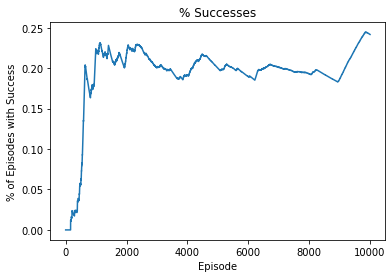

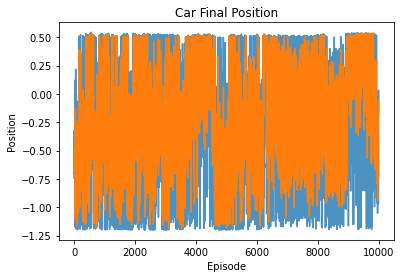

In [ ]:
import pandas as pd
from PIL import Image 

if NOTEBOOK == 1:
    plt.plot(successes)
    plt.xlabel('Episode')
    plt.ylabel('% of Episodes with Success')
    plt.title('% Successes')
    plt.show()
    plt.close()

    p = pd.Series(position)
    ma = p.rolling(3).mean()
    plt.plot(p, alpha=0.8)
    plt.plot(ma)
    plt.xlabel('Episode')
    plt.ylabel('Position')
    plt.title('Car Final Position')
    plt.show()

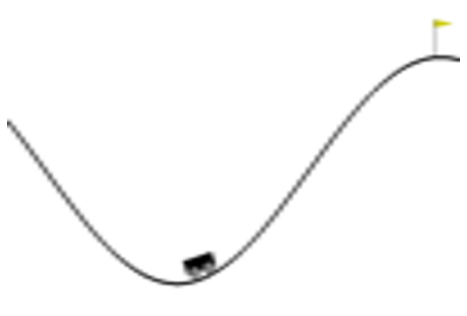

In [ ]:
#### Video plotting code #####################
if NOTEBOOK == 1:
  deep_frames = []
  for obs in frames:
    im = Image.fromarray(np.uint8(obs))
    im = im.resize((600,400))
    deep_frames.append(np.asarray(im))

  plt.figure(figsize=(deep_frames[0].shape[1] / 72.0, deep_frames[0].shape[0] / 72.0), dpi = 72)
  patch = plt.imshow(deep_frames[0])
  plt.axis('off')
  animate = lambda i: patch.set_data(deep_frames[i])
  ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(deep_frames), interval = 50)
  HTML(ani.to_jshtml())
